### CPS 330 ML Project

Sudoku!!


Helpful sources: 

https://www.kaggle.com/datasets/rohanrao/sudoku?resource=download

http://pi.math.cornell.edu/~mec/Summer2009/Mahmood/Count.html

https://www.activestate.com/blog/solving-sudoku-with-python-and-artificial-intelligence/

Use appendix B. of text to advise project development


Most sources use CNN


# 1) Frame the problem

# 2) Get the data (plus some tools)

In [1]:
# Preliminary imports and variable assigments
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.metrics import RootMeanSquaredError as rmse
from sklearn.model_selection import train_test_split

np.random.seed(42)

# ANSI Color Codes for highlighting errors
ANSI_RESET = "\u001B[0m"
ANSI_RED = "\u001B[31m"

# Print Sudoku with hightlighted errors from solved puzzle and solution 2d arrays
def checkError(puzzle, solution):
    result = " "
    for i in range(len(puzzle)):
        for j in range(len(puzzle)):
            if (j % 9 == 0):
                result += "\n "
            elif (j % 3 == 0):
                result += " |"
            result += " "
            result += ANSI_RED + str(puzzle[i][j]) + ANSI_RESET if puzzle[i][j] != solution[i][j] else str(puzzle[i][j])
        if (((i + 1) % 3 == 0) & (i < 8)):
            result += "\n -------+-------+-------"
    print(result)

def plot(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

2022-12-06 17:49:56.130055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 9 million soduku puzzles and solutions...
df = pd.read_csv('sudoku.csv', nrows=500000) 

# 3) Explore to gain insights

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   puzzle    500000 non-null  object
 1   solution  500000 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [4]:
df.loc[:,"puzzle"][0]

'070000043040009610800634900094052000358460020000800530080070091902100005007040802'

In [5]:
df.loc[:,"solution"][0]

'679518243543729618821634957794352186358461729216897534485276391962183475137945862'

Each sudoku puzzle is stored in a 81 digit string. The best way to handle these strings is to parse them into 2-dimensional arrays?

In [6]:
# Attempted to use np.fromstring() to parse string into (9,9) array but function has depreciated

# Parse a string into a returned 9x9 numpy array
def stringToGrid(nums):
    grid = np.empty((9,9), dtype=np.int8)
    for i in range(0, 9):
        for j in range(0, 9):
            grid[i][j] = nums[9*i + j]
    return grid

# Print grid from string
def printString(nums):
    result = " "
    for i in range(0, len(nums)):
        if (i % 9 == 0):
            result += "\n "
        elif (i % 3 == 0):
            result += " |"
        if ((i % 27 == 0) & (i != 0)):
            result += "-------+-------+-------\n "
        result += " " + nums[i]
    print(result)
    
# Better to use this one now that puzzles/solutions will be handled as np.arrays
# Print grid from np.array
def printGrid(array):
    result = " "
    for row in range(0,9):
        for col in range(0,9):
            if (col % 9 == 0):
                result += "\n "
            elif (col % 3 == 0):
                result += " |"
            result += " " + str(array[row][col])
        if (((row + 1) % 3 == 0) & (row < 8)):
            result += "\n -------+-------+-------"
    print(result)

In [7]:
printString(df.loc[:,"puzzle"][0])

 
  0 7 0 | 0 0 0 | 0 4 3
  0 4 0 | 0 0 9 | 6 1 0
  8 0 0 | 6 3 4 | 9 0 0
 -------+-------+-------
  0 9 4 | 0 5 2 | 0 0 0
  3 5 8 | 4 6 0 | 0 2 0
  0 0 0 | 8 0 0 | 5 3 0
 -------+-------+-------
  0 8 0 | 0 7 0 | 0 9 1
  9 0 2 | 1 0 0 | 0 0 5
  0 0 7 | 0 4 0 | 8 0 2


In [8]:
printGrid(stringToGrid(df.loc[:,"puzzle"][0]))

 
  0 7 0 | 0 0 0 | 0 4 3
  0 4 0 | 0 0 9 | 6 1 0
  8 0 0 | 6 3 4 | 9 0 0
 -------+-------+-------
  0 9 4 | 0 5 2 | 0 0 0
  3 5 8 | 4 6 0 | 0 2 0
  0 0 0 | 8 0 0 | 5 3 0
 -------+-------+-------
  0 8 0 | 0 7 0 | 0 9 1
  9 0 2 | 1 0 0 | 0 0 5
  0 0 7 | 0 4 0 | 8 0 2


In [9]:
def report(puzzles):
    arr = []
    for puzzle in puzzles:
        arr.append(len(puzzle) - puzzle.count('0'))
    print("STD: %.4f." % np.std(arr), \
         "Min: %d clues" % arr[np.argmin(arr)], "in puzzle %d." % np.argmin(arr), \
         "Max: %d clues" % arr[np.argmax(arr)], "in puzzle %d." % np.argmax(arr), \
         "Mean: %.4f." % np.mean(arr))

In [10]:
report(df.loc[:,"puzzle"])

STD: 6.1101. Min: 23 clues in puzzle 24529. Max: 77 clues in puzzle 6035. Mean: 38.9108.


The contextual clue average is actually quite higher than I thought and there is quite a large variety between puzzles. Perhaps a multi-output classifier could work. It's also reasonable that a multilabel classification algorithm could do well, since that tends to be how I would solve a sudoku puzzle. 

# 4) Prepare data to expose data patterns

In [11]:
# Attempted to use np.fromstring() to parse string into (9,9) array but function has depreciated

# Parse a string into a returned 9x9 numpy array
# def stringToGrid(nums):
#     grid = np.empty((9,9), dtype=np.int8)
#     for i in range(0, 9):
#         for j in range(0, 9):
#             grid[i][j] = nums[9*i + j]
#     return grid

def norm(a):
    return (a/9)-.5

def denorm(a):
    return (a+.5)*9

# Reshape DataFrame and split into subsets
def processData(data):
    X = np.array([np.array(list(x)).astype(np.uint8).reshape(9,9) for x in data.puzzle])
    y = np.array([np.array(list(x)).astype(np.uint8).reshape(9,9) for x in data.solution])
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_train, X_test, y_train, y_test = processData(df)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400000, 9, 9), (400000, 9, 9), (100000, 9, 9), (100000, 9, 9))

In [14]:
X_train[0]

array([[4, 1, 0, 0, 0, 0, 0, 5, 0],
       [5, 8, 7, 1, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 8, 5, 9, 7, 0, 0, 1],
       [2, 7, 0, 0, 0, 3, 0, 0, 4],
       [0, 5, 0, 0, 0, 1, 8, 7, 0],
       [7, 0, 0, 6, 0, 0, 2, 3, 0],
       [0, 3, 0, 0, 2, 0, 0, 0, 9],
       [1, 2, 0, 0, 8, 9, 7, 6, 0]], dtype=uint8)

# 5) Explore different models

In [15]:
# Clean out keras backend
keras.backend.clear_session()

### Basic 3-Layer Dense Model

In [16]:
# model attempt 0

model0 = keras.models.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(81,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(81, activation='softmax')
])

2022-12-06 17:50:53.434506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 17:50:53.443685: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               10496     
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 81)                10449     
                                                                 
Total params: 37,457
Trainable params: 37,457
Non-trainable params: 0
_________________________________________________________________


In [18]:
model0.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])

In [19]:
X, y = X_train.reshape(-1,81), y_train.reshape(-1,81)

Epoch 1/2
12500/12500 [==============================] - 32s 3ms/step - loss: 31.4732 - accuracy: 0.0342
Epoch 2/2
12500/12500 [==============================] - 30s 2ms/step - loss: 31.4708 - accuracy: 0.0353


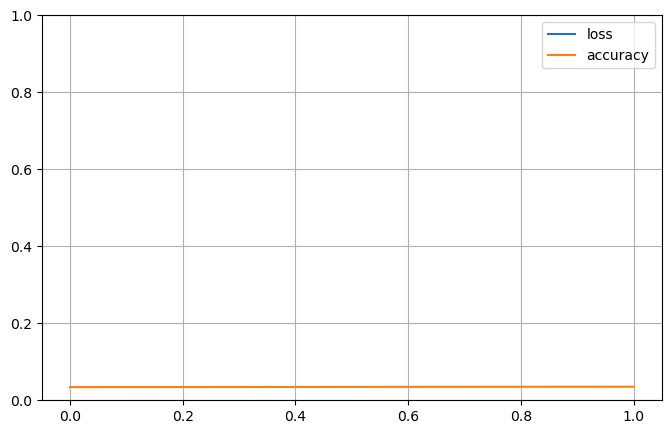

In [20]:
plot(model0.fit(X, y, epochs=2))

In [21]:
checkError(np.round(model0.predict(X_test[0].reshape(-1,81)).reshape(9,9)).astype(int), y_test[0])

1/1 [==============================] - 0s 111ms/step
 
  0 0 0 | 0 0 0 | 0 0 0
  0 0 0 | 0 0 0 | 0 0 0
  0 0 0 | 0 0 0 | 0 0 1
 -------+-------+-------
  0 0 0 | 0 0 0 | 0 0 0
  0 0 0 | 0 0 0 | 0 0 0
  0 0 0 | 0 0 0 | 0 0 0
 -------+-------+-------
  0 0 0 | 0 0 0 | 0 0 0
  0 0 0 | 0 0 0 | 0 0 0
  0 0 0 | 0 0 0 | 0 0 0


This is obviously incorrect, lets try a model with less dense layers

### Convolutional Model

In [22]:
# model attempt 1

model1 = keras.models.Sequential([
    keras.layers.Conv2D(81, (3,3), activation='relu', padding="same", input_shape=(9,9,1)),
    keras.layers.Conv2D(81, (3,3), activation='relu', padding="same"),
    keras.layers.Dense(1, activation='linear'),
])

# 10% accuracy

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 81)          810       
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 81)          59130     
                                                                 
 dense_3 (Dense)             (None, 9, 9, 1)           82        
                                                                 
Total params: 60,022
Trainable params: 60,022
Non-trainable params: 0
_________________________________________________________________


In [24]:
model1.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])

Epoch 1/2
12500/12500 [==============================] - 281s 23ms/step - loss: 3.2085 - accuracy: 0.1111
Epoch 2/2
12500/12500 [==============================] - 316s 25ms/step - loss: 3.1939 - accuracy: 0.1111


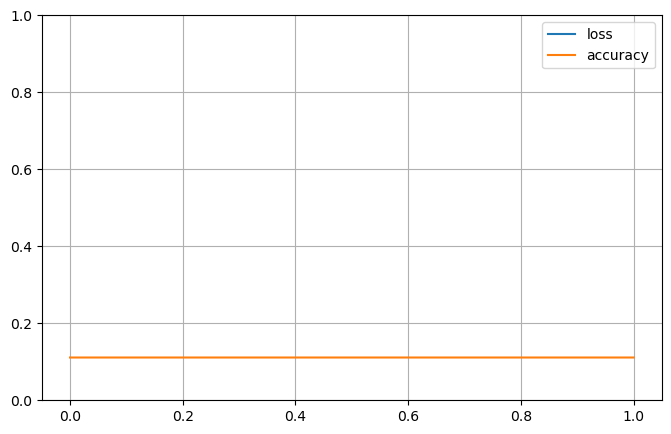

In [26]:
# 9 million puzzles is a lot. 
# For some reason the webpage reloads and I lose progress frequently. 
# For the sake of time, this training is reduced
plot(model1.fit(X_train, y_train, epochs=2))

In [27]:
checkError(np.around(model1.predict(X_test[:1])).reshape(9,9).astype(int), y_test[:1].astype(int).squeeze())

1/1 [==============================] - 0s 72ms/step
 
  9 5 5 | 7 1 7 | 6 2 5
  4 5 6 | 6 5 2 | 6 6 3
  5 2 7 | 3 4 6 | 5 5 9
 -------+-------+-------
  6 4 2 | 6 6 5 | 5 5 5
  3 7 6 | 6 5 5 | 6 5 1
  1 6 5 | 5 5 5 | 5 6 5
 -------+-------+-------
  6 3 5 | 2 9 5 | 5 5 4
  5 5 9 | 4 5 6 | 5 5 6
  5 5 5 | 6 3 1 | 6 8 5


Looking a lot more accurate. Prediction seems to perform a lot better when data isn't normalized, interesting. 

### 10-Layer Convolutional Neural Network with Dense Activation Layer

In [28]:
# model attempt 2
model2 = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', padding="same", input_shape=(9,9,1)),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding="same"),
    keras.layers.Dense(1, activation='linear'),
])

In [29]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 9, 9, 32)          320       
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 128)         36992     
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 128)         147584    
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 128)         147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         147584    
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 128)         147584    
                                                                 
 conv2d_8 (Conv2D)           (None, 9, 9, 128)        

In [30]:
model2.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])

12500/12500 [==============================] - 976s 78ms/step - loss: 2.6280 - accuracy: 0.1109


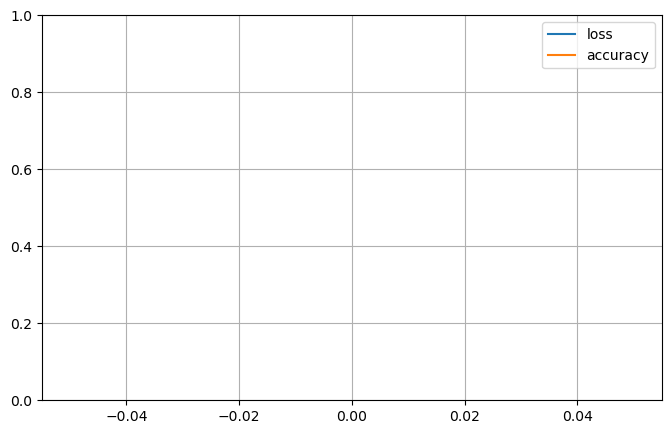

In [31]:
plot(model2.fit(X_train, y_train, epochs=1))

In [32]:
checkError(np.around(model2.predict(X_test[:1])).reshape(9,9).astype(int), y_test[:1].astype(int).squeeze())

1/1 [==============================] - 0s 91ms/step
 
  9 5 5 | 7 1 7 | 5 2 5
  6 5 6 | 9 5 2 | 4 5 3
  5 2 2 | 3 4 7 | 6 5 9
 -------+-------+-------
  6 4 2 | 2 6 6 | 7 6 6
  3 7 8 | 6 5 6 | 5 5 1
  1 9 5 | 4 5 5 | 5 6 6
 -------+-------+-------
  5 3 4 | 2 9 8 | 5 5 4
  4 4 9 | 4 6 5 | 3 4 6
  5 6 5 | 6 3 1 | 6 8 5


### Convolutional Model with Dropout

In [33]:
# model attempt 3
model3 = keras.models.Sequential([
    keras.layers.Conv2D(64, (3,3), activation='relu', padding="same", input_shape=(9,9,1)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(32, (3,3), activation='relu', padding="same"),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(16, (3,3), activation='relu', padding="same"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='linear'),
])

# < 1.0 RSME? But accuracy is 10% still

In [34]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 9, 9, 64)          640       
                                                                 
 dropout (Dropout)           (None, 9, 9, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 9, 9, 32)          18464     
                                                                 
 dropout_1 (Dropout)         (None, 9, 9, 32)          0         
                                                                 
 conv2d_13 (Conv2D)          (None, 9, 9, 16)          4624      
                                                                 
 dropout_2 (Dropout)         (None, 9, 9, 16)          0         
                                                                 
 dense_5 (Dense)             (None, 9, 9, 1)          

In [35]:
model3.compile(loss="mean_squared_error", optimizer="adam", metrics=['accuracy'])

Epoch 1/2
12500/12500 [==============================] - 513s 41ms/step - loss: 4.5518 - accuracy: 0.1069
Epoch 2/2
12500/12500 [==============================] - 478s 38ms/step - loss: 3.8416 - accuracy: 0.1032


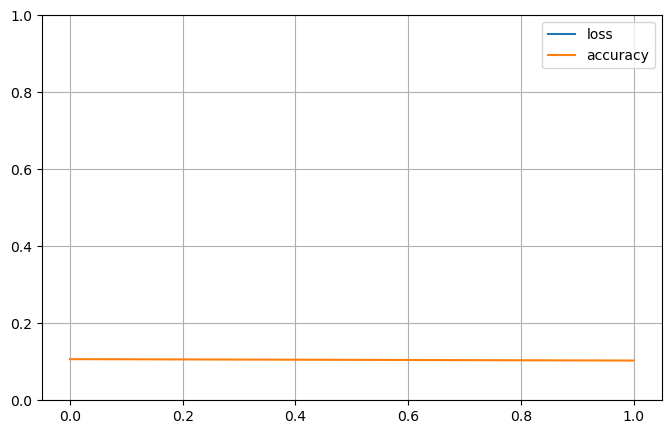

In [36]:
plot(model3.fit(X_train, y_train, epochs=2))

In [37]:
checkError(np.around(model3.predict(X_test[:1])).reshape(9,9).astype(int), y_test[:1].astype(int).squeeze())

1/1 [==============================] - 0s 95ms/step
 
  8 5 5 | 5 2 6 | 6 3 5
  4 5 6 | 6 5 2 | 6 6 3
  5 3 6 | 3 4 5 | 5 5 8
 -------+-------+-------
  6 4 2 | 6 5 6 | 5 5 5
  3 7 5 | 6 5 5 | 5 5 2
  2 6 5 | 5 5 5 | 5 6 5
 -------+-------+-------
  6 3 5 | 2 8 5 | 5 4 4
  5 5 8 | 4 5 5 | 5 5 6
  5 5 5 | 6 3 2 | 5 8 5


### Complex Convolutional Network on Individual Squares

The above models are not as accurate as they can be. As regression problems they do their best to guess a 9x9 grid of numbers based on a provided puzzle. Lets create a model that can refine its weights and be applied to empty squares one by one to calculate their predicted values. This should preserve the accuracy of the already half solved puzzle. 

Credit: https://www.kaggle.com/code/yashchoudhary/deep-sudoku-solver-multiple-approaches

In [38]:
from keras.utils import Sequence

#Utility Functions
class DataGenerator(Sequence):
    def __init__(self, df,batch_size = 16,subset = "train",shuffle = False, info={}):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.subset = subset
        self.info = info
        
        self.data_path = path
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df)/self.batch_size))
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle==True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self,index):
        X = np.empty((self.batch_size, 9,9,1))
        y = np.empty((self.batch_size,81,1))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['quizzes'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = (np.array(list(map(int,list(f)))).reshape((9,9,1))/9)-0.5
        if self.subset == 'train': 
            for i,f in enumerate(self.df['solutions'].iloc[indexes]):
                self.info[index*self.batch_size+i]=f
                y[i,] = np.array(list(map(int,list(f)))).reshape((81,1)) - 1
        if self.subset == 'train': return X, y
        else: return X

In [44]:
path = './'
data = pd.read_csv(path+"sudoku.csv", nrows=500000)
try:
    data = pd.DataFrame({"quizzes":data["puzzle"],"solutions":data["solution"]})
except:
    pass

In [45]:
train_idx = int(len(data)*0.95)
data = data.sample(frac=1).reset_index(drop=True)
training_generator = DataGenerator(data.iloc[:train_idx], subset = "train", batch_size=640)
validation_generator = DataGenerator(data.iloc[train_idx:], subset = "train",  batch_size=640)

In [78]:
test = data.iloc[train_idx:]
test.shape

(25000, 2)

In [79]:
X_test, y_test = test.quizzes, test.solutions

In [88]:
X_test.iloc[0], y_test.iloc[0]

('008304200049706000010000049000072853000980601030060024026140090000005100100000400',
 '578394216249716385613258749961472853452983671837561924326147598794835162185629437')

In [2]:
import numpy as np
import pandas as pd
import keras
import keras.backend as K
from keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import *
import matplotlib.pyplot as plt

model4 = keras.models.Sequential()

model4.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
model4.add(BatchNormalization())
model4.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model4.add(BatchNormalization())
model4.add(Conv2D(128, kernel_size=(1,1), activation='relu', padding='same'))

model4.add(Flatten())
model4.add(Dense(81*9))
model4.add(Reshape((-1, 9)))
model4.add(Activation('softmax'))

adam = keras.optimizers.Adam(learning_rate=.001)
model4.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy']) # consider sparse_categorical_crossentropy

2022-12-06 19:52:33.007177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jakeypoo/opt/anaconda3/envs/cps330/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-12-06 19:52:39.472153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 64)          640       
                                                                 
 batch_normalization (BatchN  (None, 9, 9, 64)         256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 batch_normalization_1 (Batc  (None, 9, 9, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         8320      
                                                                 
 flatten (Flatten)           (None, 10368)             0

In [47]:
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
filepath1="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath2 = "best_weights.hdf5"
checkpoint1 = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    min_lr=1e-6
)
callbacks_list = [checkpoint1,checkpoint2,reduce_lr]

In [48]:
history = model4.fit(training_generator, validation_data = validation_generator, epochs = 5, verbose=1,callbacks=callbacks_list )

Epoch 1/5
742/742 [==============================] - ETA: 0s - loss: 1.0517 - accuracy: 0.1174
Epoch 1: val_accuracy improved from -inf to 0.10285, saving model to weights-improvement-01-0.10.hdf5

Epoch 1: val_accuracy improved from -inf to 0.10285, saving model to best_weights.hdf5
742/742 [==============================] - 236s 317ms/step - loss: 1.0517 - accuracy: 0.1174 - val_loss: 0.7304 - val_accuracy: 0.1028 - lr: 0.0010
Epoch 2/5
742/742 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.1101
Epoch 2: val_accuracy improved from 0.10285 to 0.11331, saving model to weights-improvement-02-0.11.hdf5

Epoch 2: val_accuracy improved from 0.10285 to 0.11331, saving model to best_weights.hdf5
742/742 [==============================] - 230s 310ms/step - loss: 0.4520 - accuracy: 0.1101 - val_loss: 0.4355 - val_accuracy: 0.1133 - lr: 0.0010
Epoch 3/5
742/742 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.1111
Epoch 3: val_accuracy did not imp

In [49]:
model4.load_weights('best_weights.hdf5')

In [50]:
### Lets solve something

import copy

def inference_sudoku(sample):
    
    '''
        This function solve the sudoku by filling blank positions one by one.
    '''
    
    feat = copy.copy(sample)
    
    while(1):
    
        #Reshape to fit model predict values
        out = model4.predict(feat.reshape((1,9,9,1)), verbose=0)  
        #Reduce dim to (81,9) predictions
        out = out.squeeze()
        
        #Rescale and reshape indices of predictions to 9x9
        pred = np.argmax(out, axis=1).reshape((9,9))+1 
        
        #round probabilities
        prob = np.around(np.max(out, axis=1).reshape((9,9)), 2) 
        
        #get and rescale/reshape puzzle
        feat = denorm(feat).reshape((9,9))
        
        # matrix of boolean values where empty square == true
        mask = (feat==0)
     
        #If there are no empty squares, break
        if(mask.sum()==0):
            break
            
        #Only include relevant probabilities
        prob_new = prob*mask
    
        #Find index of highest probability
        ind = np.argmax(prob_new)
        x, y = (ind//9), (ind%9)

        #Set respective coordinate grid position to value
        val = pred[x][y]
        feat[x][y] = val
        
        #re-normalize? 
        feat = norm(feat)
    
    return pred

def test_accuracy(feats, labels):
    
    correct = 0
    
    for i,feat in enumerate(feats):
        
        pred = inference_sudoku(feat)
        
        true = labels[i].reshape((9,9))+1
        
        if(abs(true - pred).sum()==0):
            correct += 1
        
    print(correct/feats.shape[0])

def solve_sudoku(game):
    
    game = game.replace('\n', '')
    game = game.replace(' ', '')
    game = np.array([int(j) for j in game]).reshape((9,9,1))
    game = norm(game)
    game = inference_sudoku(game)
    return game

In [92]:
for i in range(10):
    solved = np.array(list(y_test.iloc[i])).astype(int).reshape(9,9)
    solution = solve_sudoku(X_test.iloc[i])
    checkError(solved, solution)

 
  5 7 8 | 3 9 4 | 2 1 6
  2 4 9 | 7 1 6 | 3 8 5
  6 1 3 | 2 5 8 | 7 4 9
 -------+-------+-------
  9 6 1 | 4 7 2 | 8 5 3
  4 5 2 | 9 8 3 | 6 7 1
  8 3 7 | 5 6 1 | 9 2 4
 -------+-------+-------
  3 2 6 | 1 4 7 | 5 9 8
  7 9 4 | 8 3 5 | 1 6 2
  1 8 5 | 6 2 9 | 4 3 7
 
  2 7 4 | 9 3 5 | 8 1 6
  9 1 8 | 2 4 6 | 3 7 5
  6 5 3 | 7 1 8 | 4 9 2
 -------+-------+-------
  1 9 5 | 3 7 4 | 2 6 8
  3 2 7 | 8 6 1 | 5 4 9
  4 8 6 | 5 9 2 | 1 3 7
 -------+-------+-------
  5 3 9 | 1 8 7 | 6 2 4
  7 4 2 | 6 5 3 | 9 8 1
  8 6 1 | 4 2 9 | 7 5 3
 
  3 9 1 | 4 8 6 | 7 5 2
  7 4 8 | 2 9 5 | 6 1 3
  6 2 5 | 1 3 7 | 4 9 8
 -------+-------+-------
  9 1 7 | 8 6 3 | 2 4 5
  2 3 6 | 5 4 9 | 8 7 1
  8 5 4 | 7 1 2 | 9 3 6
 -------+-------+-------
  1 6 9 | 3 7 8 | 5 2 4
  5 7 3 | 6 2 4 | 1 8 9
  4 8 2 | 9 5 1 | 3 6 7
 
  7 5 3 | 2 4 9 | 6 8 1
  2 8 1 | 7 5 6 | 3 9 4
  6 9 4 | 3 1 8 | 7 2 5
 -------+-------+-------
  9 1 2 | 8 7 4 | 5 6 3
  8 4 6 | 9 3 5 | 1 7 2
  3 7 5 | 6 2 1 | 9 4 8
 -------+-------+-------
